In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qutip import Options
from qutip.nonmarkov.bofin import BathExponent, DrudeLorentzPadeBath, HEOMSolver
from qutip.operators import identity, sigmax, sigmaz, sigmam, sigmap
from qutip.superoperator import liouvillian
from qutip.tensor import tensor

### Setup

In this notebook, we apply the QuTiP HEOM solver to a quantum system coupled to two bosonic baths and demonstrate how to extract information about the system-bath heat currents from the auxiliary density operators (ADOs).
We consider the setup described in [\[Kato 2015\]](https://doi.org/10.1063/1.4928192), which consists of two coupled qubits, each connected to its own heat bath.
The Hamiltonian of the qubits is given by
$$ \begin{aligned} &H_{\text{sys}} = H_1 + H_2 + H_{12} , \quad\text{ where }\\
&H_k = \frac{\omega}{2} \bigl(\sigma_z^k + 1\bigr) \quad  (k=1,2) \quad\text{ and }\quad H_{12} = J_{12} \bigl( \sigma_+^1 \sigma_-^2 + \sigma_-^1 \sigma_+^2 \bigr) . \end{aligned} $$
Here, $\sigma^k_{x,y,z,\pm}$ denotes the usual Pauli matrices for the $k$-th qubit, $\omega$ is the eigenfrequency of the qubits and $J_{12}$ a dimensionless coupling constant.
Note that we set $\hbar$ and $k_B$ to one and we will measure all frequencies and energies in units of $\omega$.

We use the parameter values from Fig. 3(a-ii) of [\[Kato 2015\]](https://doi.org/10.1063/1.4928192):

In [2]:
# Qubit parameters
omega = 1
J12 = 0.1

# System operators
H1 = omega / 2 * tensor(sigmaz() + identity(2), identity(2))
H2 = omega / 2 * tensor(identity(2), sigmaz() + identity(2))
H12 = J12 * (tensor(sigmap(), sigmam()) + tensor(sigmam(), sigmap()))
Hsys = H1 + H2 + H12

Each qubit is coupled to its own bath and the total Hamiltonian is
$$ H_{\text{tot}} = H_{\text{sys}} + \sum_{k=1,2} \bigl( H_B^k + Q_k \otimes X_B^k \bigr) , $$
where $H_B^k$ is the free Hamiltonian of the $k$-th bath and $X_B^k$ its coupling operator, and $Q_k = \sigma_x^k$ are the system coupling operators.
We assume that the bath spectral densities are given by Drude distributions
$$ I_k(\omega) = \frac{\zeta_k \gamma_k \omega}{\omega^2 + \gamma_k^2} , $$
where $\zeta_k$ is the free coupling strength and the cutoff frequencies $\gamma_k$ are chosen like in Fig. 3(a-ii):

In [3]:
# Cutoff frequencies
gamma1 = 2
gamma2 = 2

# Temperatures
Tbar = 2
Delta_T = 0.01 * Tbar
T1 = Tbar + Delta_T
T2 = Tbar - Delta_T

# Coupling operators
Q1 = tensor(sigmax(), identity(2))
Q2 = tensor(identity(2), sigmax())

### Heat currents

Following [\[Kato 2016\]](https://doi.org/10.1063/1.4971370), we consider two possible definitions of the heat currents from the qubits into the baths.
The so-called bath heat currents are $J_B^k = \partial_t \langle H_B^k \rangle$ and the system heat currents are $J_S^k = \mathrm i\, \langle [H_{\text{sys}}, Q_k] X_B^k \rangle$.
As shown in [\[Kato 2016\]](https://doi.org/10.1063/1.4971370), they can be expressed in terms of the HEOM ADOs as follows:
$$ \begin{aligned}
    J_B^k &= \!\!\sum_{\substack{\mathbf n\\ \text{Level 1}\\ \text{Bath $k$}}}\!\! \nu[\mathbf n] \operatorname{tr}\bigl[ Q_k \rho_{\mathbf n} \bigr] - 2 \Im[C_k(0)] \operatorname{tr}\bigl[ Q_k^2 \rho \bigr] + \Delta_k \operatorname{tr}\bigl[ [[H_{\text{sys}}, Q_k], Q_k]\, \rho \bigr] , \\[.5em]
    J_S^k &= \mathrm i\!\! \sum_{\substack{\mathbf n\\ \text{Level 1}\\ \text{Bath $k$}}}\!\! \operatorname{tr}\bigl[ [H_{\text{sys}}, Q_k]\, \rho_{\mathbf n} \bigr] + \Delta_k \operatorname{tr}\bigl[ [[H_{\text{sys}}, Q_k], Q_k]\, \rho \bigr] .
\end{aligned} $$
The sums run over all level-$1$ multi-indices $\mathbf n$ with one excitation corresponding to the $k$-th bath, $\nu[\mathbf n]$ is the corresponding (negative) exponent of the bath auto-correlation function $C_k(t)$, and $\Delta_k$ is a correction term accounting for the error introduced by approximating $C_k(t)$ with a finite sum of exponential terms.
In the expression for the bath heat currents, we left out terms involving $[Q_1, Q_2]$, which is zero in this example.

In QuTiP, the currents can be conveniently calculated as follows:

In [4]:
# bath_tag: tag of the k-th bath
# coupling_op: Q_k
# ado_state: of type HierarchyADOsState
# delta: coefficient of the \delta(t) term in the correlation function (as defined in [Kato 2016])
def bath_heat_current(bath_tag, ado_state, hamiltonian, coupling_op, delta=0):
    l1_labels = ado_state.filter(level=1, tags=[bath_tag])
    a_op = 1j * (hamiltonian * coupling_op - coupling_op * hamiltonian)

    result = 0
    cI0 = 0 # imaginary part of bath auto-correlation function (t=0)
    for label in l1_labels:
        [exp] = ado_state.exps(label)
        contribution = (coupling_op * ado_state.extract(label)).tr()
        result += exp.vk * contribution

        if exp.type == BathExponent.types['I']:
            cI0 += exp.ck
        elif exp.type == BathExponent.types['RI']:
            cI0 += exp.ck2

    result -= 2 * cI0 * (coupling_op * coupling_op * ado_state.rho).tr()
    if delta != 0:
        result -= 1j * delta * ((a_op * coupling_op - coupling_op * a_op) * ado_state.rho).tr()
    return result

def system_heat_current(bath_tag, ado_state, hamiltonian, coupling_op, delta=0):
    l1_labels = ado_state.filter(level=1, tags=[bath_tag])
    a_op = 1j * (hamiltonian * coupling_op - coupling_op * hamiltonian)

    result = 0
    for label in l1_labels:
        contribution = (a_op * ado_state.extract(label)).tr()
        result += contribution

    if delta != 0:
        result -= 1j * delta * ((a_op * coupling_op - coupling_op * a_op) * ado_state.rho).tr()
    return result

Note that at long times, we expect $J_B^1 = -J_B^2$ and $J_S^1 = -J_S^2$ due to energy conservation. At long times, we also expect $J_B^1 = J_S^1$ and $J_B^2 = J_S^2$ since the coupling operators commute, $[Q_1, Q_2] = 0$. Hence, all four currents should agree in the long-time limit (up to a sign). This long-time value is also what was calculated in [\[Kato 2015\]](https://doi.org/10.1063/1.4928192).

### Simulations

We fix some numerical parameters: we will represent the bath spectral densities using only the first term of their Padé expansions, and we'll use $7$ levels of the HEOM hierarchy.

In [5]:
num_exponentials = 1
heom_cutoff = 7
options = Options(nsteps=1500, store_states=False, atol=1e-12, rtol=1e-12)

##### Example 1

We choose the fixed coupling strength $\zeta_1 = \zeta_2 = J_{12} / 2$ (corresponding to $\bar\zeta = 1$ in [\[Kato 2015\]](https://doi.org/10.1063/1.4928192)) and consider the time evolution of the system state and the heat currents.

In [6]:
# fix coupling strength
zeta = J12 / 2
# choose arbitrary initial state
rho0 = tensor(identity(2), identity(2)) / 4
# simulation time span
tlist = np.linspace(0, 50, 250)

In [7]:
bath1 = DrudeLorentzPadeBath(Q1, zeta, T1, num_exponentials, gamma1, terminator=True, tag='bath 1')
bath2 = DrudeLorentzPadeBath(Q2, zeta, T2, num_exponentials, gamma2, terminator=True, tag='bath 2')

solver = HEOMSolver(liouvillian(Hsys) + bath1.terminator + bath2.terminator,
                    [bath1, bath2], heom_cutoff, options=options)

result = solver.run(rho0, tlist, e_ops=[tensor(sigmaz(), identity(2)),
                                        lambda t, ado: bath_heat_current('bath 1', ado, Hsys, Q1, bath1.delta),
                                        lambda t, ado: bath_heat_current('bath 2', ado, Hsys, Q2, bath2.delta),
                                        lambda t, ado: system_heat_current('bath 1', ado, Hsys, Q1, bath1.delta),
                                        lambda t, ado: system_heat_current('bath 2', ado, Hsys, Q2, bath2.delta)])

We first plot $\langle \sigma_z^1 \rangle$ to see the time evolution of the system state:

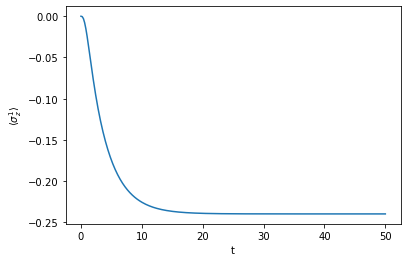

In [8]:
plt.plot(tlist, result.expect[0])
plt.xlabel('t')
plt.ylabel(r"$\langle \sigma_z^1 \rangle$")
plt.show()

We find a rather quick thermalization of the system state. For the heat currents, however, it takes a longer time until they converge to their long-time values:

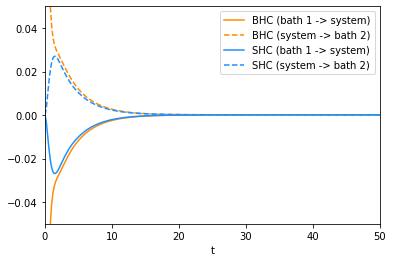

In [9]:
plt.plot(tlist, -np.real(result.expect[1]), color='darkorange', label='BHC (bath 1 -> system)')
plt.plot(tlist, np.real(result.expect[2]), '--', color='darkorange', label='BHC (system -> bath 2)')
plt.plot(tlist, -np.real(result.expect[3]), color='dodgerblue', label='SHC (bath 1 -> system)')
plt.plot(tlist, np.real(result.expect[4]), '--', color='dodgerblue', label='SHC (system -> bath 2)')
plt.xlabel('t')
plt.axis((0, 50, -0.05, 0.05))
plt.legend()
plt.show()

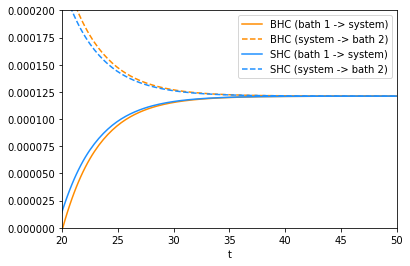

In [10]:
plt.plot(tlist, -np.real(result.expect[1]), color='darkorange', label='BHC (bath 1 -> system)')
plt.plot(tlist, np.real(result.expect[2]), '--', color='darkorange', label='BHC (system -> bath 2)')
plt.plot(tlist, -np.real(result.expect[3]), color='dodgerblue', label='SHC (bath 1 -> system)')
plt.plot(tlist, np.real(result.expect[4]), '--', color='dodgerblue', label='SHC (system -> bath 2)')
plt.xlabel('t')
plt.axis((20, 50, 0, 0.0002))
plt.legend()
plt.show()

##### Example 2

Here, we try to reproduce the HEOM curve in Fig. 3(a-ii) of [\[Kato 2015\]](https://doi.org/10.1063/1.4928192) by varying the coupling strength and finding the steady state for each coupling strength.

In [11]:
def heat_currents(zeta_bar):
    bath1 = DrudeLorentzPadeBath(Q1, zeta_bar * J12 / 2, T1, num_exponentials, gamma1, terminator=True, tag='bath 1')
    bath2 = DrudeLorentzPadeBath(Q2, zeta_bar * J12 / 2, T2, num_exponentials, gamma2, terminator=True, tag='bath 2')
    solver = HEOMSolver(liouvillian(Hsys) + bath1.terminator + bath2.terminator,
                        [bath1, bath2], heom_cutoff, options=options)
    
    _, steady_ados = solver.steady_state()
    return bath_heat_current('bath 1', steady_ados, Hsys, Q1, bath1.delta), \
           bath_heat_current('bath 2', steady_ados, Hsys, Q2, bath2.delta), \
           system_heat_current('bath 1', steady_ados, Hsys, Q1, bath1.delta), \
           system_heat_current('bath 2', steady_ados, Hsys, Q2, bath2.delta)

In [12]:
# Define number of points to use for final plot
plot_points = 81

In [13]:
from ipywidgets import IntProgress
from IPython.display import display

progress = IntProgress(min=0, max=plot_points)
display(progress)

zeta_bars = []
j1s = []
j2s = []
j3s = []
j4s = []

for zb in np.logspace(-2, 2, plot_points):
    if zb > 10:
        heom_cutoff = 12
    if zb > 50:
        heom_cutoff = 15
    if zb > 75:
        heom_cutoff = 18

    zeta_bars.append(zb)
    j1, j2, j3, j4 = heat_currents(zb)
    progress.value += 1

    j1s.append(j1)
    j2s.append(j2)
    j3s.append(j3)
    j4s.append(j4)

progress.close()

IntProgress(value=0, max=81)

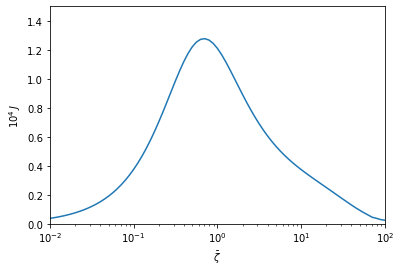

In [14]:
plt.plot(zeta_bars, -1e4 * np.real(j1s))

plt.xscale('log')
plt.xlabel(r"$\bar\zeta$")
plt.ylabel(r"$10^4\, J$")
plt.axis((0.01, 100, 0, 1.5))
plt.show()

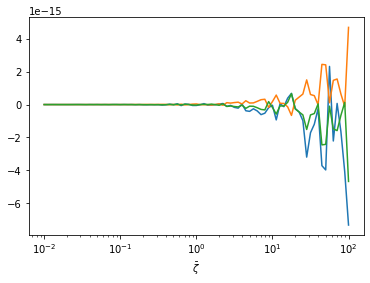

In [15]:
# Sanity check: all 4 currents should be identical
plt.plot(zeta_bars, np.real(j2s) + np.real(j1s))
plt.plot(zeta_bars, np.real(j3s) - np.real(j1s))
plt.plot(zeta_bars, np.real(j4s) + np.real(j1s))

plt.xscale('log')
plt.xlabel(r"$\bar\zeta$")
plt.show()